# 3. Leaky Aquifer Test - Texas Hill

### Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import timflow.transient as tft

plt.rcParams['figure.figsize'] = [5, 3]

### Introduction and Conceptual Model

This example, taken from the AQTESOLV examples (Duffield, 2007), is a pumping test done in the location of 'Texas Hill'. 

A pumping well was screened at an aquifer located between 20 ft and 70 ft depths. The aquifer is overlain by an aquitard. The formation at the base of the aquifer is considered an aquiclude.

Three observation wells are located at 40, 80 160 ft distance. They are denominated OW1, OW2 and OW3, respectively. Pumping lasted for 420 minutes at a rate of 4488 gallons per minute. 

<img src="./figs/Texas_Hill.png" style="width:400pt">

### Load data

In [10]:
# data of OW1 
data1 = np.loadtxt("data/texas40.txt")
t1 = data1[:, 0] #days
h1 = data1[:, 1] #meters
r1 = 40 * 0.3048 # distance between obs1 to pumping well in m (40 ft = 12.191 m)

# data of OW2
data2 = np.loadtxt("data/texas80.txt")
t2 = data2[:, 0]
h2 = data2[:, 1]
r2 = 80 * 0.3048 # distance between obs2 to pumping well in m (80 ft = 24.383 m)

# data of OW3
data3 = np.loadtxt("data/texas160.txt")
t3 = data3[:, 0]
h3 = data3[:, 1]
r3 = 160 * 0.3048 # distance between obs3 to pumping well in m (160 ft = 48.766 m)

### Parameters and model

In [12]:
# known parameters 
Q = (4488 * 0.00378541) * 60 * 24 # constant discharge in m^3/d (4488 gallons/minute = 24464.06 m^3/d)
b1 = 20 * 0.3048 # overlying aquitard thickness in m (20 ft = 6.096 m)
b2 = 50 * 0.3048 # aquifer thickness in m (50 ft = 15.24 m )
zt = -b1  # top boundary of aquifer, m
zb = -b1 - b2  # bottom boundary of aquifer, m
rw = 0.5 * 0.3048 # well radius in m (0.5 ft = 0.15 m)

The overlying layer is modeld as an aquitard without storage (```Sll```, the storage parameter, is set to zero in ModelMaq).

In [14]:
ml= tft.ModelMaq(
    kaq=10,
    z=[0, zt, zb],
    Saq=0.001,
    Sll=0,
    c=10,
    tmin=0.001,
    tmax=1,
    topboundary="semi",
)
w = tft.Well(ml, xw=0, yw=0, rw=rw, tsandQ=[(0, Q)], layers=0)
ml.solve()

self.neq  1
solution complete


### Estimate aquifer parameters
The hydraulic parameters of the aquifer (```kaq``` and ```Saq```) and for the aquitard (```c```) are estimated. 

In [33]:
# unknown parameters: kaq, Saq, c
cal = tft.Calibrate(ml)
cal.set_parameter(name="kaq", layers=0, initial=10)
cal.set_parameter(name="Saq", layers=0, initial=1e-4)
cal.set_parameter(name="c", layers=0, initial=100)
cal.series(name="OW1", x=r1, y=0, t=t1, h=h1, layer=0)
cal.series(name="OW2", x=r2, y=0, t=t2, h=h2, layer=0)
cal.series(name="OW3", x=r3, y=0, t=t3, h=h3, layer=0)
cal.fit()

......................................................
Fit succeeded.


In [34]:
display(cal.parameters.loc[:, ['optimal']])
print("RMSE:", cal.rmse())

,optimal
kaq_0_0,224.628844
Saq_0_0,0.000213
c_0_0,43.882032


RMSE: 0.060243076833231254


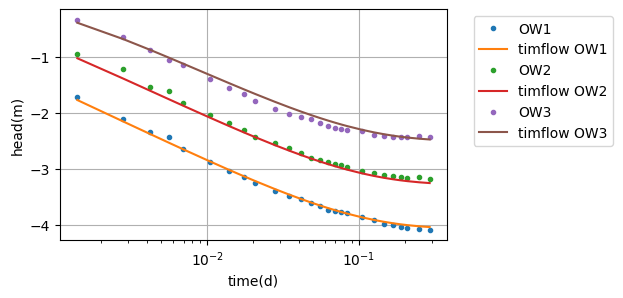

In [48]:
hm1_1 = ml.head(r1, 0, t1)
hm2_1 = ml.head(r2, 0, t2)
hm3_1 = ml.head(r3, 0, t3)
plt.semilogx(t1, h1, ".", label="OW1")
plt.semilogx(t1, hm1_1[0], label="timflow OW1")
plt.semilogx(t2, h2, ".", label="OW2")
plt.semilogx(t2, hm2_1[0], label="timflow OW2")
plt.semilogx(t3, h3, ".", label="OW3")
plt.semilogx(t3, hm3_1[0], label="timflow OW3")
plt.xlabel("time(d)")
plt.ylabel("head(m)")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid()

### Comparison of Results 

Here, the aquifer responses obtained with `timflow` are compared to the results based on Hantush’s analytical solution (Hantush, 1955), implemented in the software AQTESOLV (Duffield, 2007). The results show almost identical values.

In [42]:
t = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "c [d]", "RMSE [m]"],
    index=["timflow", "AQTESOLV"],
)

t.loc["AQTESOLV"] = [224.726, 2.125e-4, 43.964, 0.059627]
t.loc["timflow"] = np.append(cal.parameters["optimal"].values, cal.rmse())

t_formatted = t.style.format(
    {"k [m/d]": "{:.2f}", "Ss [1/m]": "{:.2e}", "c [d]": "{:.2f}", "RMSE [m]": "{:.2f}"}
)
t_formatted

,k [m/d],Ss [1/m],c [d],RMSE [m]
timflow,224.63,2.13e-04,43.88,0.06
AQTESOLV,224.73,2.12e-04,43.96,0.06


## References

* Carlson F. and Randall J. (2012), MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems, Ground Water 50(4):504–510.
* Duffield, G.M. (2007), AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Newville, M.,Stensitzki, T., Allen, D.B. and Ingargiola, A. (2014), LMFIT: Non Linear Least-Squares Minimization and Curve Fitting for Python, https://dx.doi.org/10.5281/zenodo.11813, https://lmfit.github.io/lmfit-py/intro.html (last access: August,2021).